# Count Mussels in an Image

Demonstrates image pre-processing, prediction and validation statistics. But first, some preliminaries...

__Note:__ To maintain a high priority Colab user status such that sufficient GPU resources are available in the future, ensure to free the runtime when finished running this notebook. This can be done using 'Runtime > Manage Sessions' and click 'Terminate'.

In [4]:
# Check if notebook is running in Colab or local workstation
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

try:
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm() 

    # Check if GPU capacity is sufficient to proceed
    if gpu.memoryFree < 10000:
        print("\nInsufficient memory! Some cells may fail. Please try restarting the runtime using 'Runtime → Restart Runtime...' from the menu bar. If that doesn't work, terminate this session and try again later.")
    else:
        print('\nGPU memory is sufficient to proceeed.')
except:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')

Gen RAM Free: 61.2 GB  | Proc size: 319.3 MB
GPU RAM Free: 9551MB | Used: 2477MB | Util  21% | Total 12028MB

Insufficient memory! Some cells may fail. Please try restarting the runtime using 'Runtime → Restart Runtime...' from the menu bar. If that doesn't work, terminate this session and try again later.


In [5]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
    
    # cd into git repo so python can find utils
    %cd '/content/drive/My Drive/cciw-zebra-mussel/predict'

    sys.path.append('/content/drive/My Drive')
    
    # clone repo, install packages not installed by default
    !pip install pydensecrf

In [6]:
import os
import os.path as osp

import glob

# for manually reading high resolution images
import cv2
import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# pytorch core library
import torch
# pytorch neural network functions
from torch import nn
# pytorch dataloader
from torch.utils.data import DataLoader

# for post-processing model predictions by conditional random field 
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

from tqdm import tqdm  # progress bar

# evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import jaccard_score as jsc

# local imports (files provided by this repo)
import transforms as T

# various helper functions, metrics that can be evaluated on the GPU
from task_3_utils import evaluate, evaluate_loss, eval_binary_iou, pretty_image

# Custom dataloader for rapidly loading images from a single LMDB file
from folder2lmdb import VOCSegmentationLMDB

In [7]:
"""Confim that this cell prints "Found GPU, cuda". If not, select "GPU" as 
"Hardware Accelerator" under the "Runtime" tab of the main menu.
"""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Found GPU,', device)

Found GPU, cuda


## 1. Load a pre-trained model checkpoint

The architecture is fully-convolutional network (FCN) 8s.

In [8]:
if IN_COLAB:
    root = osp.join(DATA_PATH, 'Checkpoints/fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1')
else:
    root = '/scratch/gallowaa/cciw/logs/lab-v1.0.0/fcn8slim/lr1e-03/wd5e-04/bs32/ep50/seed1/checkpoint' # a
    #root = '/scratch/gallowaa/cciw/logs/v1.0.1-debug/fcn8s/lr1e-03/wd5e-04/bs25/ep80/seed4/checkpoint' # b
    #root = '/scratch/gallowaa/cciw/logs/v1.1.0-debug/fcn8s/lr1e-03/wd5e-04/bs25/ep80/seed9/checkpoint/' # c
    #root = '/scratch/gallowaa/cciw/logs/v111/trainval/fcn8s/lr1e-03/wd5e-04/bs40/ep80/seed2/checkpoint/' # d
    #root = '/scratch/gallowaa/cciw/logs/v111/trainval/fcn8slim/lr1e-04/wd5e-04/bs40/ep80/seed1/checkpoint/' # e

ckpt_file = 'fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1_epoch40.ckpt' # a
#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs25_ep80_seed4_epoch70.ckpt' # b
#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs25_ep80_seed9_epoch10.ckpt'
#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs40_ep80_seed2amp_epoch40.pt' # d
#ckpt_file = 'fcn8slim_lr1e-04_wd5e-04_bs40_ep80_seed1amp_epoch79.pt' # e

"""Feel free to try these other checkpoints later after running epoch40 to get a 
feel for how the evaluation metrics change when model isn't trained as long."""
#ckpt_file = 'fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1_epoch10.ckpt'
#ckpt_file = 'fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1_epoch0.ckpt'

checkpoint = torch.load(osp.join(root, ckpt_file))
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
print('==> Resuming from checkpoint..')
net = checkpoint['net']
last_epoch = checkpoint['epoch']
torch.set_rng_state(checkpoint['rng_state'])
'''
# AMP
net.load_state_dict(checkpoint['net'])
#amp.load_state_dict(checkpoint['amp'])
last_epoch = checkpoint['epoch'] + 1
torch.set_rng_state(checkpoint['rng_state'])
'''
# later appended to figure filenames
model_stem = ckpt_file.split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print('Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

==> Resuming from checkpoint..
Loaded model fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1_epoch40 trained to epoch  40
Cross-entropy loss 0.0807 for train set, 0.1903 for validation set


In [9]:
from apex import amp

In [10]:
net = amp.initialize(net, opt_level='O3')

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0


## 2. Define Image Pre-Processing Transforms and Data Augmentation

Here, we define transforms to be applied to input images (`inputs`) and segmentation masks (`targets`)
on the fly as we draw mini-batches like:

```
for inputs, targets in dataloader:
    pass
```

These transforms are documented here: https://pytorch.org/docs/stable/torchvision/transforms.html

We may wish to experiment with additional ones in the future, e.g., `ColorJitter` to perturb the image colours, 
or `Grayscale` to convert the dataset to Greyscale and quantify the marginal impact of colour information on model performance.

In [11]:
training_tforms = []

# Randomly crop images to square 224x224
training_tforms.append(T.RandomCrop(224)) 

# With probability 0.5, flip the images and masks horizontally.
# This increases the effective size of our training set, as 
# mussels are rotation invariant.
training_tforms.append(T.RandomHorizontalFlip(0.5)) 

# Similarly, flip the images and masks vertically with probability 0.5.
training_tforms.append(T.RandomVerticalFlip(0.5))

# Convert images from Python Imaging Library (PIL aka Pillow) format to PyTorch Tensor.
training_tforms.append(T.ToTensor())

"""
T.Normalize performs: image = (image - mean) / std

The first argument (a triple) to T.Normalize are the global 
RGB pixel mean values, and the second argument is their standard deviation. 

For a mini-batch 'inputs' comprised of N samples, 
C channels, e.g. 3 for RGB images, height H, width W, and 
inputs.shape = torch.Size([N, C, H, W]), this can be obtained using:

inputs.mean(dim=(0, 2, 3)), which will output a tensor, e.g., 
tensor([0.2613, 0.2528, 0.2255]). 

The standard deviation can be obtained similarly with:
inputs.std(dim=(0, 2, 3))

The global values can simply be obtained by averaging over all 
mini-batches in the dataset.

For the natural mussel dataset (i.e. not the Lab images), 
these global pixel values are somewhat meaningless to due 
significant changes in lighting and hue, so we simply
pass the triple (0.5, 0.5, 0.5) for both mean and std to
normalize the input image pixels from [0, 1] to [-1, 1]. 
This centers the images and resulting feedforward activations 
around zero and allows training to proceed more smoothly.
"""
training_tforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

# Finally, Compose several transforms together.
training_tforms = T.Compose(training_tforms)

For validation and testing, we often want these transforms to be deterministic to be sure the model is making progress with respect to the natural image distribution. We will evaluate on fixed 250x250 patches rather than randomly cropping.

For evaluating robustness, we could add `ColorJitter` and do scaling or shearing with various Affine transforms here...

In [12]:
test_tform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 3. Create Efficient Data Loaders

Specify the mini-batch size (`batch_size`) for validation, and path to serialized LMDB dataset `dataset_root`. 

The `batch_size` is arbitrary at test time since we aren't using `nn.BatchNorm()`, the main consideration here 
is to use the largest `batch_size` the GPU memory allows to maximize throughput. The default setting should be fine.

In [13]:
batch_size = 50

if IN_COLAB:
    dataset_root = osp.join(DATA_PATH, 'Lab_dataset_train_validation/LMDB/')
else:
    #dataset_root = '/scratch/ssd/gallowaa/cciw/LMDB'
    dataset_root = '/scratch/ssd/gallowaa/cciw/Lab'

The `VOCSegmentationLMDB` class was adapted from https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCSegmentation
to enable reading data from a single `*.lmdb` database which is much more efficient on conventional hard drives than randomly reading images.

Note that transforms provided to the `transforms` argument apply to both input images and masks. 
The label values will be rotated accordingly as the input images, but the labels are unaffected by the normalization due to being limited to values 0/1.

In [14]:
validation_set = VOCSegmentationLMDB(
    root=osp.join(dataset_root, 'val_v100.lmdb'), transforms=test_tform)

val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [ ]:
training_set = VOCSegmentationLMDB(
    root=osp.join(dataset_root, 'train_v111.lmdb'), transforms=test_tform)

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

To compute the `pos_weight` from the dataset, uncomment the following cell.
Note that the `batch_pos_weight` may be `inf` for a batch comprised entirely of 
masks without any mussels. Increase the `batch_size` to avoid this.

In [ ]:
total_mussel = 0.
total_pixels = 0.
for idx, data in enumerate(val_loader):
    total_mussel += (data[1] == 1).sum().float().item()
    total_pixels += (data[1] == 0).sum().float().item()
    print('Batch %d of %d, pos_weight=%.4f' % (idx, len(val_loader), total_mussel / total_pixels))
print('pos_weight={:.4f}'.format(total_pixels / total_mussel))

In [16]:
pos_weight = torch.FloatTensor([12.4924]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

sig = nn.Sigmoid()  # initializes a sigmoid function

## 4. Compute training and validation cross-entropy losses

to ensure model was loaded correctly and that the data were pre-processed in consistent manner w.r.t. the training script.

Note: the cross-entropy loss is a proxy for what we ultimately want to measure, the intersection of the prediction and masks divided by their union.

In [ ]:
calculate_validation_loss = evaluate_loss(net, val_loader, loss_fn, device)
assert np.allclose(calculate_validation_loss, val_loss, atol=1e-3)
print('\n Validation loss of {:.4f} matches checkpoint'.format(calculate_validation_loss))

In [ ]:
# note: train loss may not match exactly 
calculate_train_loss = evaluate_loss(net, train_loader, loss_fn, device)

print('\n Calculated train loss of {:.4f}'.format(calculate_train_loss))
print('\n Checkpoint train loss of {:.4f}'.format(train_loss))

## 5. Compute the Mean Intersection-over-Union (mIoU) Score on the Validation Set

The mean Intersection-over-Union (IoU), aka Jaccard Score or Jaccard Index, on the validation/test dataset is 
the main performance metric we use to evaluate semantic segmentation models.

Detail: using `torch.no_grad()` saves memory if we will not be 
doing error backpropagation as intermediate activations can be 
discarded. Otherwise these are retained in GPU memory in case 
we want to compute gradients. See https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad.

In [17]:
batch = 0
running_iou = 0

net.eval()

with torch.no_grad():
    
    for inputs, targets in tqdm(val_loader, unit=' images', unit_scale=batch_size):
        inputs, targets = inputs.to(device), targets.to(device)
        
        """Apply the sigmoid function here so that output lies in [0, 1]. 
        Previously it was applied internally by the loss_fn.
        
        This line does a feedforward pass, or prediction."""
        pred = sig(net(inputs))
        
        bin_iou = eval_binary_iou(pred.round(), targets)
        
        if (bin_iou > 0).sum() > 1:
            iou = bin_iou[bin_iou > 0].mean().item()
            running_iou += iou
            batch += 1
    running_iou = running_iou / batch

print('\n mIoU = %.4f' % running_iou)  # 0.8638 for epoch40 model

100%|██████████| 1350/1350 [00:06<00:00, 235.30 images/s]


 mIoU = 0.8646


## 6. Visualize Validation Predictions on 250x250 Patches

In [ ]:
nhwc = inputs.permute(0, 2, 3, 1).detach().cpu().numpy()
pred_np = pred.detach().cpu().numpy()
targets_np = targets.detach().cpu().numpy()

# put pixels back into range [0, 1] for matplotlib
nhwc = (nhwc * 0.5) + 0.5

print(nhwc.shape)
print(nhwc.min(), nhwc.max())

In [ ]:
j = 4  # change me! (in 0 to 45)

N_PLOTS = 4
fig, ax = plt.subplots(1, N_PLOTS, figsize=(16, 4))

ax[0].imshow((nhwc[j]))
ax[1].imshow(pred_np[j].squeeze())
ax[2].imshow(pred_np[j].round().squeeze())
ax[3].imshow(targets_np[j])

for i in range(N_PLOTS):
    ax[i].axis('off')

## 7. i) Visualize Predictions on Whole Images

Here we manually load and preprocess the original images and png masks using OpenCV.

`root_path` -- will also be used in 

In [164]:
if IN_COLAB:
    root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/Test/Lab/')
else:
    root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'
    #root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Validation-v101-originals/'
    #root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Train/2018-06/land/'

jpeg_files = glob.glob(root_path + '*.jpg')
#png_files = glob.glob(root_path + '*.png') # for lab
png_files = glob.glob(root_path + '*final.png') # for lab

# in-situ
#jpeg_files = glob.glob(osp.join(root_path, 'JPEGImages/') + '*.jpg')
#png_files = glob.glob(osp.join(root_path, 'SegmentationClass/') + '*_crop.png')

jpeg_files.sort()
png_files.sort()

# Both should equal 36 for v1.0.0 Lab dataset
print(len(jpeg_files)) 
print(len(png_files))

40
36


In [165]:
"""
These are the full resolution files that correspond to the 1350 patches of 
the validation split `val_v100.lmdb`."""
'''
val_mask = png_files[-5:]
val_jpeg = jpeg_files[-5:]
val_jpeg
'''

'\nval_mask = png_files[-5:]\nval_jpeg = jpeg_files[-5:]\nval_jpeg\n'

In [20]:
"""Set to True to save the model predictions in PNG format, 
otherwise proceed to predict biomass without saving images"""
SAVE_PREDICTIONS = False

if SAVE_PREDICTIONS:
    prediction_path = ''
    for t in root.split('/')[:-1]:
        prediction_path += t + '/'

    prediction_path = osp.join(prediction_path, 'predictions')

    if not osp.exists(prediction_path):
        os.mkdir(prediction_path)

    # src is the training dataset, tgt is the testing dataset
    src = 'val_100'
    #tgt = 'val_100'
    #tgt = '2018-06'

In [21]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

In [22]:
sx = 1000
sy = 600
w = 2000
#plt.imshow(imgc[sy:sy+w, sx:sx+w, :])

In [146]:
jpeg_files[29]

'/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/Lab_3788-1_2018-07-05_image-1.jpg'

Image 29 of 36, IoU 0.8938


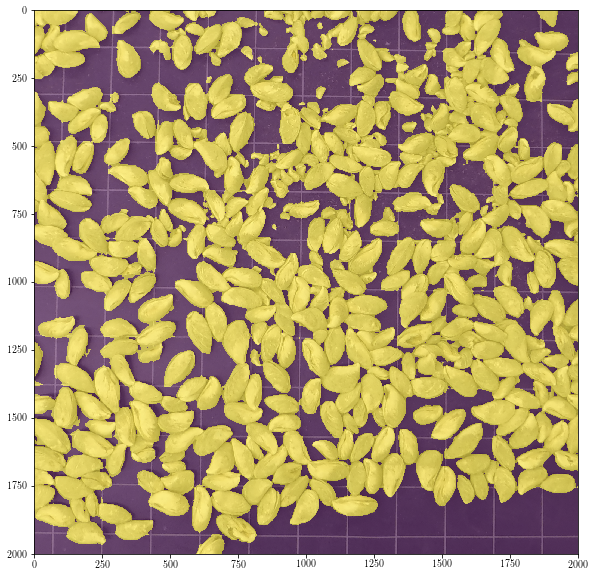

In [147]:
#for i in range(len(val_jpeg)):
i = 29

image_stem = jpeg_files[i].split('/')[-1].split('.')[0]

bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)

bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

imgc = imgc[sy:sy+w, sx:sx+w, :]
labc = labc[sy:sy+w, sx:sx+w, :]
image = imgc.copy()

# pre-processing image consistent with PyTorch training transforms
imgc = imgc / 255
imgc = ((imgc - np.array([0.5, 0.5, 0.5])) / np.array([0.5, 0.5, 0.5]))

imgt = torch.FloatTensor(imgc).to(device)
imgt = imgt.unsqueeze(0)

# Note: need to call contigious after the permute 
# else max pooling will fail
nchw_tensor = imgt.permute(0, 3, 1, 2).contiguous()

with torch.no_grad():
    pred = sig(net(nchw_tensor))
pred_np = pred.detach().cpu().numpy().squeeze()

# OpenCV loads the PNG mask as indexed color RGB, 
# we need to convert it to a binary mask. 
# The `0' in labc[:, :, 0] is the R channel.
mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
mask[labc[:, :, 0] == 128] = 1    

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
jaccard_fcn = jsc(pred_np.round().reshape(-1, 1), mask.reshape(-1, 1))
print('Image %d of %d, IoU %.4f' % (i, len(jpeg_files), jaccard_fcn))

#image = cv2.cvtColor(bgr_img[sy:sy+w, sx:sx+w, :], cv2.COLOR_BGR2RGB)

#fig, axes = plt.subplots(1, 1, figsize=(10, 4))
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
#axes = axes.flatten()
#axes[0].imshow(image)
#axes[0].set_title('Input', fontsize=fontsize)
axes.imshow(image, alpha=0.75)
axes.imshow(pred_np.round(), alpha=0.5)
#axes[1].set_title('Input \& Preds, IoU = %.4f' % jaccard_fcn, fontsize=fontsize)
#axes[2].imshow(mask)
#axes[2].set_title('Ground Truth Segmentation', fontsize=fontsize)
#plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
#pretty_image(axes)
#plt.tight_layout()

if SAVE_PREDICTIONS:
    #filename = src + '-' + tgt + '__' + image_stem + '_patch_width%d' % w + '__' + model_stem
    filename = src + '-' + tgt + '__' + image_stem + '__' + model_stem
    out_file = osp.join(prediction_path, filename)
    fig.savefig(out_file + '.png', format='png')
    fig.savefig(out_file + '.eps', format='eps')

In [161]:
thresh = (pred_np.round() * 255).astype('uint8')

# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

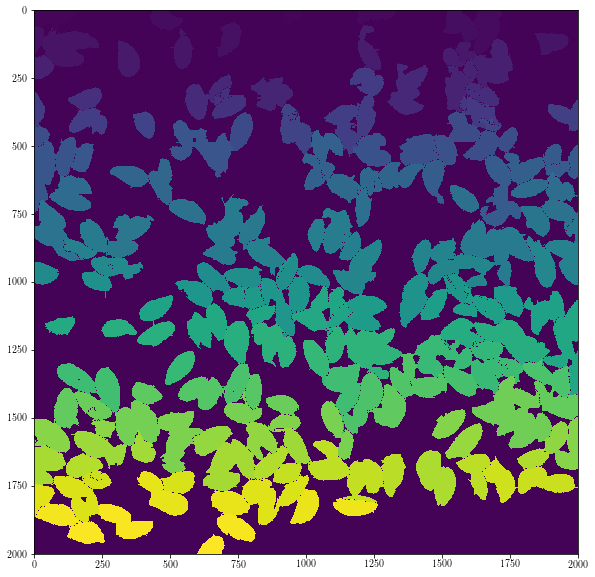

In [162]:
plt.figure(figsize=(10, 10))
plt.imshow(markers)

In [163]:
vals, cts = np.unique(markers, return_counts=True)

In [160]:
vals
#plt.hist(cts[2:])

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int32)

In [166]:
def count_mussels(image, predictions):
    """ Counts mussels in predicted output.
    
    @param predictions: greyscale predictions as float in [0, 1]
    """
    #thresh = (predictions * 255).astype('uint8')

    # noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(predictions, cv2.MORPH_OPEN, kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    ret, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)
    #image[markers == -1] = [255, 0, 0]
    
    return np.unique(markers)[-1]

In [28]:
np.unique(markers)

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52], dtype=int32)

### 7. ii) Refine the Predictions with Post-Processing by CRF

Notice the sand in the middle of the image index `i=0` which is initially prediced as mussel. The CRF excels at 
suppressing such false positives and mIoU increases by 10 pts. Unfortunately it introduces some spurious detection 
of grid lines, thus doesn't help on all images. Meta-parameters of the CRF can be tuned further.

In [ ]:
def run_crf(rgb, pred_np):
    """
    Takes an input image and corresponding model predictions, then 
    runs a conditional random field (CRF) on the predictions.
    
    @param rgb: is an rgb image in uint8 format (pixels 0-255)
    @param pred_np: are model predictions in greyscale format as float [0,1]
    """
    MAX_ITER = 20
    labels = np.stack([pred_np, 1 - pred_np])
    c, h, w = labels.shape[0], labels.shape[1], labels.shape[2]
    labels = labels.astype('float') / labels.max()
    U = utils.unary_from_softmax(labels)
    U = np.ascontiguousarray(U)
    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    """
    @param compat=3, Potts model - it introduces a penalty for nearby similar 
    pixels that are assigned different labels. 
    """
    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=3, compat=6)
    
    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    # im is an image-array, e.g. im.dtype == np.uint8
    d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=rgb, compat=10)
    
    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    
    # binarize output
    Q[0][Q[0] >= 0.5] = 1
    Q[0][Q[0] < 0.5] = 0
    
    return Q[0, :, :]

In [ ]:
pred_crf = run_crf(image, pred_np)
jaccard_crf = jsc(pred_crf.reshape(-1, 1), mask.reshape(-1, 1))
print('CRF IoU %.4f' % jaccard_crf)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()
axes[0].imshow(image)
axes[0].set_title('Input', fontsize=fontsize)
axes[1].imshow(image, alpha=0.75)
axes[1].imshow(pred_np.round(), alpha=0.5)
axes[1].set_title('FCN Preds, IoU = %.4f' % jaccard_fcn, fontsize=fontsize)

axes[2].imshow(image, alpha=0.75)
axes[2].imshow(pred_crf, alpha=0.5)
axes[2].set_title('Post CRF Preds, IoU = %.4f' % jaccard_crf, fontsize=fontsize)

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
pretty_image(axes)

if SAVE_PREDICTIONS:
    filename = src + '-' + tgt + '__' + image_stem + '_patch_width%d_crf' % w + '__' + model_stem
    #filename = src + '-' + tgt + '__' + image_stem + '__' + model_stem
    out_file = osp.join(prediction_path, filename)
    fig.savefig(out_file + '.png', format='png')
    fig.savefig(out_file + '.eps', format='eps')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title('Input')

axes[1].imshow(mask)
axes[1].set_title('Ground Truth Segmentation', fontsize=fontsize)

axes[2].imshow(image, alpha=0.75)
axes[2].imshow(pred_np.round(), alpha=0.5)
axes[2].set_title('Input \& Soft Preds, IoU = %.4f' % jaccard_fcn, fontsize=fontsize)

axes[3].imshow(image, alpha=0.75)
axes[3].imshow(pred_crf, alpha=0.5)
axes[3].set_title('Input \& CRF Preds, IoU = %.4f' % jaccard_crf, fontsize=fontsize)

pretty_image(axes)

## 8. Predict Mussel Biomass

Here we predict the mussel biomass from the lab analysis using a) the masks, and b) model predictions on the 
full size images. 

In [167]:
if not IN_COLAB:
    DATA_PATH = r'/scratch/gallowaa/cciw/Data'

imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [30]:
"""
numpy array with manually estimated camera distance based on counting 
squares along horizontal and vertical axes of each Lab image.

Useful to determine how much performance can be gained by accounting 
for camera distance programmatically."""
scale = np.load('lab_board_dims.npy')

Relates to Deliverable 2. c) *Predicted semantic segmentation (mussel/no-mussel) for all images in 2019 testing set in png image format.*

In [168]:
lab_ct = []  # for storing the number of mussel pixels in each mask
prd_ct = []  # for storing the number of mussel pixels in each prediction

# This cell is slow because we're randomly reading large images from Google Drive
for i in tqdm(range(len(jpeg_files)), unit=' image'):
    
    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
    #bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
    
    #_, cts = np.unique(bgr_lab, return_counts=True)
    #lab_ct.append(cts[1] / cts.sum())    
    
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    #lab = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
    
    image = img.copy()

    # pre-processing image consistent with PyTorch training transforms
    img = img / 255.
    img = ((img - np.array([0.5, 0.5, 0.5])) / np.array([0.5, 0.5, 0.5]))

    imgt = torch.FloatTensor(img).to(device)
    imgt = imgt.unsqueeze(0)

    # Note: need to call contigious after the permute 
    # else max pooling will fail
    nchw_tensor = imgt.permute(0, 3, 1, 2).contiguous()

    with torch.no_grad():
        pred = sig(net(nchw_tensor))
    
    pred_np = pred.squeeze().round().detach().cpu().numpy()
    prd_ct.append(count_mussels(image, (pred_np * 255).astype('uint8') ))
    
    #grey_mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='uint8')
    #grey_mask[lab[:, :, 0] == 128] = 255
    #lab_ct.append(count_mussels(image, grey_mask))
    
    #prd_ct.append(pred.round().sum().item() / cts.sum())

    if SAVE_PREDICTIONS:
        '''
        prediction = (pred.squeeze().round() * 255)
        prediction_np = prediction.detach().cpu().numpy().astype('uint8')
        out_file = osp.join(prediction_path, 
                            jpeg_files[i].split('/')[-1].split('.')[0] + '_' + ckpt_file.split('.')[0] + '.png')
        cv2.imwrite(out_file, prediction_np)
        '''

100%|██████████| 40/40 [01:07<00:00,  1.81s/ image]


In [383]:
CORRECT_CAMERA_DISTANCE = False

lab_ct_np = np.asarray(lab_ct)
prd_ct_np = np.asarray(prd_ct)

lab_targets = np.zeros((len(jpeg_files), 3)) # 0 = biomass, 1 = count

names = ['16mm', '14mm', '12.5mm', '10mm', '8mm', '6.3mm', '4mm', '2mm']
sieves = np.array([16, 14, 12.5, 10, 8, 6.3, 4, 2])

for i in range(len(jpeg_files)):
    
    # adjust the pixel_ct by size of grid (16 squares high, 25 wide)
    if CORRECT_CAMERA_DISTANCE:
        lab_ct_np[i] = lab_ct_np[i] * (np.prod(scale[i]) / (16 * 25))
        prd_ct_np[i] = prd_ct_np[i] * (np.prod(scale[i]) / (16 * 25))
    
    '''
    if 'scale' in png_files[i]:
        root_fname = png_files[i].split('/')[-1].split('.')[0].split('_scale')[0][4:-8]
    else:
        root_fname = png_files[i].split('/')[-1].split('.')[0].split('_mask')[0][4:-8]
    ''' 
    root_fname = jpeg_files[i].split('/')[-1].split('.')[0].split('_image')[0].split('Lab_')[1]
    
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    lab_targets[i, 0] = row['Biomass'].values
    lab_targets[i, 1] = row['Count'].values
    
    size_dist = np.zeros(len(names))
    for j in range(len(names)):
        size_dist[j] = row[names[j]].values
        
    lab_targets[i, 2] = (lab_targets[i, 0] * size_dist * (2 / sieves)**(1/3)).sum()
        
#lab_ct_np = lab_ct_np / lab_ct_np.max()    
prd_ct_np = prd_ct_np / prd_ct_np.max()

lab_targets[np.isnan(lab_targets)] = 0
#y = lab_targets[:, 1] / lab_targets[:, 1].max()
#yc = lab_targets[:, 2] / lab_targets[:, 2].max()

In [380]:
(2 / sieves) ** (1/3)

array([0.5       , 0.52275796, 0.54288352, 0.58480355, 0.62996052,
       0.68217607, 0.79370053, 1.        ])

In [375]:
sieves

array([16. , 14. , 12.5, 10. ,  8. ,  6.3,  4. ,  2. ])

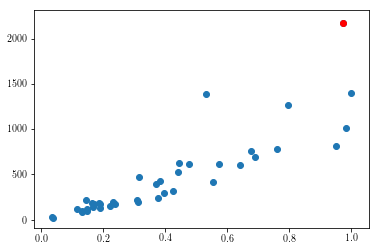

In [285]:
#lab_targets
y = lab_targets[:, 1]
t = 1500
plt.scatter(prd_ct_np, y)
plt.scatter(prd_ct_np[y > t], y[y > t], c='r')

In [377]:
bio = lab_targets[:, 0] / lab_targets[:, 0].max()
count = lab_targets[:, 1] / lab_targets[:, 1].max()
cc = lab_targets[:, 2] / lab_targets[:, 2].max()

/export/mlrg/gallowaa/anaconda2-5.1/envs/torch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/export/mlrg/gallowaa/anaconda2-5.1/envs/torch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


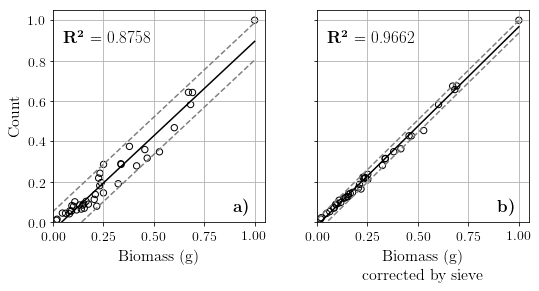

In [382]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].scatter(bio, count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].scatter(bio, cc, marker='o', s=40, facecolors='none', edgecolors='k')
#ax[0].set_ylabel('Mussel Biomass (grams)', fontsize=fontsize)
ax[0].set_ylabel('Count', fontsize=fontsize)
ax[0].set_ylim(0, 1.05)
ax[0].set_xlim(0, 1.05)
ax[0].set_xlabel('Biomass (g)', fontsize=fontsize)
ax[1].set_xlabel('Biomass (g) \n corrected by sieve', fontsize=fontsize)
ax[0].tick_params(labelsize=fontsize-2)
ax[1].tick_params(labelsize=fontsize-2)

x = np.linspace(0, 1)

A = np.vstack([bio, np.ones(len(bio))]).T
#m, c = np.linalg.lstsq(A, count, rcond=None)[0]
(m, c), res, r, s = np.linalg.lstsq(A, count)
std = np.sqrt(res[0] / len(cc))
ax[0].plot(x, m*x + c, 'k', linestyle='-')
ax[0].plot(x, m * x + c + 1.96 * std, '--', color='gray')
ax[0].plot(x, m * x + c - 1.96 * std, '--', color='gray')

#m, c = np.linalg.lstsq(A, cc, rcond=None)[0]
(m, c), res, r, s = np.linalg.lstsq(A, cc)
std = np.sqrt(res[0] / len(cc))
ax[1].plot(x, m*x + c, 'k', linestyle='-')
ax[1].plot(x, m * x + c + 1.96 * std, '--', color='gray')
ax[1].plot(x, m * x + c - 1.96 * std, '--', color='gray')

ax[0].annotate(r'$\mathbf{R^2}$ = %.4f' % r2_score(bio, count), 
            xy=(.05, .85), fontsize=fontsize + 1, xycoords='axes fraction', color='k')
ax[1].annotate(r'$\mathbf{R^2}$ = %.4f' % r2_score(bio, d), 
            xy=(.05, .85), fontsize=fontsize + 1, xycoords='axes fraction', color='k')

ax[0].annotate(r'\textbf{a)}', xy=(.85, .05), fontsize=fontsize + 1, xycoords='axes fraction', color='k')
ax[1].annotate(r'\textbf{b)}', xy=(.85, .05), fontsize=fontsize + 1, xycoords='axes fraction', color='k')

ax[0].grid()
ax[1].grid()
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

plt.tight_layout()

In [372]:
fname = 'lab_count_from_biomass'
fig.savefig(fname + '.png')
fig.savefig(fname + '.eps', format='eps')

Finally, plot biomass versus pixels predicted as mussel. Interestingly, the 
model **predictions** outperform the **masks** in terms of accounting for 
variance in biomass. This holds both when `CORRECT_CAMERA_DISTANCE=True` or `=False`.

This is likely due to a CLT-style smoothing effect, or the model paying "equal 
attention" to all images, whereas the Lab images were labelled by different 
people (myself and Scale) and likely have idiosyncrasies.

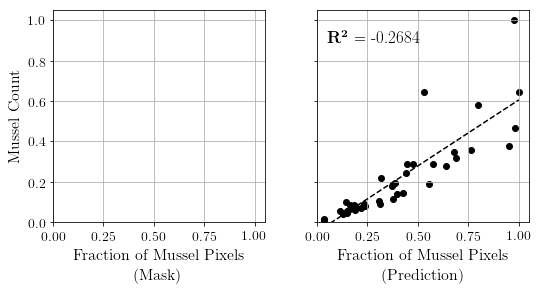

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

#ax[0].scatter(lab_ct_np, y, marker='o', s=40, facecolors='none', edgecolors='b')
ax[1].scatter(prd_ct_np, y, c='k') #, marker='o', s=40, facecolors='none', edgecolors='k')
#ax[0].set_ylabel('Mussel Biomass (grams)', fontsize=fontsize)
ax[0].set_ylabel('Mussel Count', fontsize=fontsize)
ax[0].set_ylim(0, 1.05)
ax[0].set_xlim(0, 1.05)
ax[0].set_xlabel('Fraction of Mussel Pixels \n (Mask)', fontsize=fontsize)
ax[1].set_xlabel('Fraction of Mussel Pixels \n (Prediction)', fontsize=fontsize)
ax[0].tick_params(labelsize=fontsize-2)
ax[1].tick_params(labelsize=fontsize-2)

x = np.linspace(0, 1)

#A = np.vstack([lab_ct_np, np.ones(len(lab_ct_np))]).T
#m, c = np.linalg.lstsq(A, y, rcond=None)[0]
#ax[0].plot(x, m*x + c, 'b', linestyle='-', label='masks')

A = np.vstack([prd_ct_np, np.ones(len(prd_ct_np))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
ax[1].plot(x, m*x + c, 'k', linestyle='--', label='preds')

#ax[0].annotate(r'$\mathbf{R^2}$ = %.4f' % r2_score(y, lab_ct_np), 
#            xy=(.05, .85), fontsize=fontsize + 1, xycoords='axes fraction', color='b')

ax[1].annotate(r'$\mathbf{R^2}$ = %.4f' % r2_score(y, prd_ct_np), 
            xy=(.05, .85), fontsize=fontsize + 1, xycoords='axes fraction', color='k')

ax[0].grid()
ax[1].grid()

#ax[0].legend(loc='lower right', fontsize=fontsize-2)
#ax[1].legend(loc='lower right', fontsize=fontsize-2)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

plt.tight_layout()

In [208]:
#tmp = 
out = (y > 0.95) & (prd_ct_np < 0.75)

In [207]:
#jpeg_files[np.argmax(out)]

In [210]:
y < 0.8

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True])

### Optionally save the plot as png or vector graphic

In [ ]:
fname = 'lab_predict_biomass_from_pixels_no_camera' + src + '-' + tgt + '__' + model_stem
fig.savefig(fname + '.png')
fig.savefig(fname + '.eps', format='eps')

# End of current demo

__ToDo:__ CSV file containing predicted (i) percentage coverage, (ii) total mussels count, (iii) total
mussels biomass and (iv) mussels size distribution with error estimates for each image
acquired in 2019. 

To do after troubleshooting performance on the *in situ* dataset.